# Probabilistic Forecasting with `sktime`

### Overview of this notebook

* probabilistic prediction: intervals, distributions - deep dive
* probability distribution objects (`skpro`)
* types of probabilistic metrics
* `skpro` tabular probabilistic regressors
* building modular `sktime` probabilistic forecasters
    * reduction from forecasting to tabular proba regression
    * reduction from tabular proba regression to tabular regression
    * feature engineering

"how to use MAPIE or ngboost for proba forecasting with `sktime`?"

In [26]:
import warnings

warnings.filterwarnings("ignore")

---
### Revisiting Probabilistic Forecasting with `sktime`

Recall the basic interval prediction vignette

In [17]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster


# step 1: data specification
y = load_airline()
# step 2: specifying forecasting horizon
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# step 3: specifying the forecasting algorithm
forecaster = ThetaForecaster(sp=12)
# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)
# step 5: querying predictions
y_pred = forecaster.predict()

# for probabilistic forecasting:
#   call a probabilistic forecasting method after or instead of step 5
y_pred_int = forecaster.predict_interval(coverage=0.9)

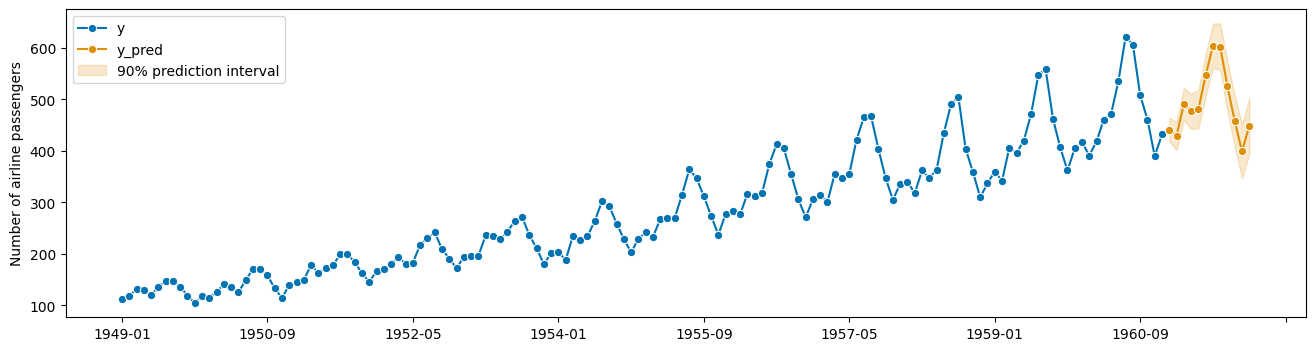

In [28]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_int
)

ax.legend();

All forecasters with tag `capability:pred_int` provide the following:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

Deep dive into these!

Let's start with distributions, the rest follows from there.

---
### Types of probabilistic forecasts, distributional forecasts

`predict_proba` produces a distributional forecast.

Let's create the return object manually for illustration,
this is what the forecaster does internally:

* forecasts for 1960-01, 1960-02, 1960-03
* expected number of passengers: 150, 250, 300
* predicted uncertainty: 50, 60, 70 standard deviation in a normal distribution

In [1]:
import pandas as pd

from skpro.distributions import Normal

timestamps = pd.period_range(start='1960-01', periods=3, freq='M')
variable_names = ["passengers"]

# the syntax is similar to pandas:
# parameters passed as arrays
# index, columns passed

mus = [[150], [250], [300]]
sigmas = [[50], [60], [70]]
n = Normal(mu=mus, sigma=sigmas, index=timestamps, columns=variable_names)

In [2]:
# this is a scikit-base compatible object
# of type "distribution", from skpro.distributions
n

Normal(columns=Index(['passengers'], dtype='object'),
       index=PeriodIndex(['1960-01', '1960-02', '1960-03'], dtype='period[M]'),
       mu=[[150], [250], [300]], sigma=[[50], [60], [70]])

we can also plot the object's pdf for illustration:

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'passengers'}, ylabel='1960-01'>,
        <Axes: ylabel='1960-02'>, <Axes: ylabel='1960-03'>], dtype=object))

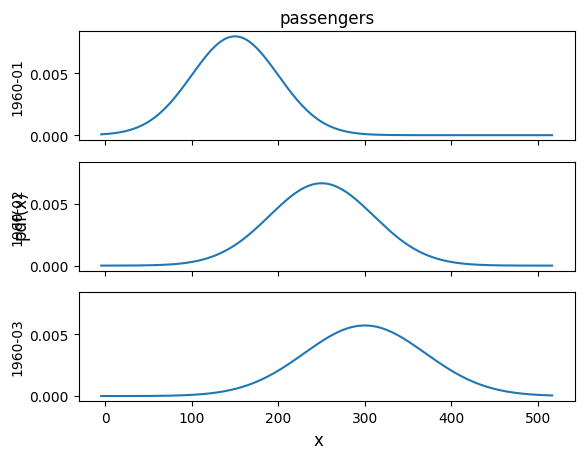

In [3]:
n.plot("pdf")

#### "pdf" = probability density function

describes how likely values are as follows:

probability for value between a and b = integral between a and b

if we sample "equally plausible futures" many times

(proabilities as according to the algorithm)

In [6]:
# one sample
n.sample()

,passengers
1960-01,208.808119
1960-02,280.983692
1960-03,177.749212


In [7]:
# another sample
n.sample()

# etc

,passengers
1960-01,173.786817
1960-02,161.968980
1960-03,350.156103


sampling is closely related to bootstrapping!

#### cdf = cumulative distribution function

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'passengers'}, ylabel='1960-01'>,
        <Axes: ylabel='1960-02'>, <Axes: ylabel='1960-03'>], dtype=object))

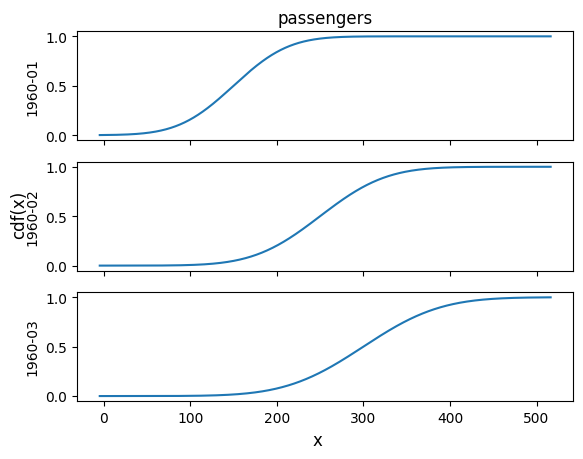

In [4]:
n.plot("cdf")

y-value = probability of value being less or equal x-value

#### ppf = percent point function or quantile function = inverse cdf

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'passengers'}, ylabel='1960-01'>,
        <Axes: ylabel='1960-02'>, <Axes: ylabel='1960-03'>], dtype=object))

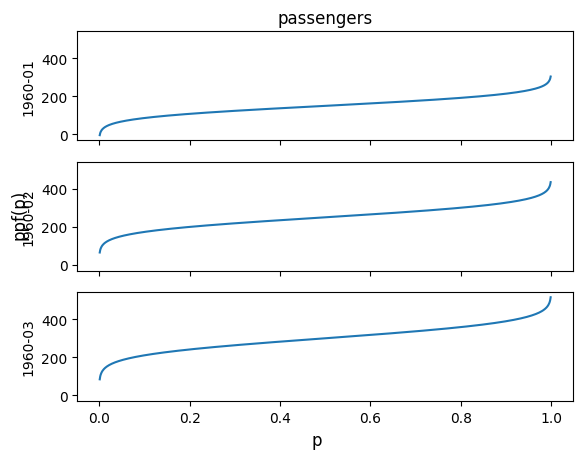

In [5]:
n.plot("ppf")

x-axis = quantile
y-axis = quantile forecast at that quantile

"p (fraction-percent) of plausible futures are below y-value" (according to algorithm)

#### How do the different forecast modes relate to the above?

`predict_var`: variance of predictive distribution

"single-number metric of uncertainty"

In [8]:
n.var()

,passengers
1960-01,2500
1960-02,3600
1960-03,4900


`predict_quantiles` - same as ppf

In [11]:
n.quantile([0.1, 0.5, 0.9])

passengers                   
                0.1    0.5         0.9
1960-01   85.922422  150.0  214.077578
1960-02  173.106906  250.0  326.893094
1960-03  210.291390  300.0  389.708610

In [15]:
[n.ppf(0.1), n.ppf(0.5), n.ppf(0.9)]

[         passengers
 1960-01   85.922422
 1960-02  173.106906
 1960-03  210.291390,
          passengers
 1960-01       150.0
 1960-02       250.0
 1960-03       300.0,
          passengers
 1960-01  214.077578
 1960-02  326.893094
 1960-03  389.708610]

`predict_interval`: we pick lower/upper so quantiles are symmetric

e.g., 0.7 coverage -> 0.15 and 0.85 quantiles

**Exercise**: compute symmetric prediction intervals at 0.6 coverage probability,

assuming the above distribution as predictive distribution



for statistics experts, not covered here for sake of simple exposition:

* dependence across time points - by default marginal
* distributions can be non-continuous, mixed, non-parametric

`skpro` supports large number of distributions

* symbolic representation of array distributions
* implementations of base methods (mostly from `scipy`) and advanced methods such as energy/crps

In [13]:
from skpro.registry import all_objects

all_objects("distribution", as_dataframe=True)

,name,object
0,Alpha,<class 'skpro.distributions.alpha.Alpha'>
1,Beta,<class 'skpro.distributions.beta.Beta'>
2,ChiSquared,<class 'skpro.distributions.chi_squared.ChiSqu...
3,Delta,<class 'skpro.distributions.delta.Delta'>
4,Empirical,<class 'skpro.distributions.empirical.Empirical'>
5,Exponential,<class 'skpro.distributions.exponential.Expone...
6,Fisk,<class 'skpro.distributions.fisk.Fisk'>
7,Gamma,<class 'skpro.distributions.gamma.Gamma'>
8,HalfCauchy,<class 'skpro.distributions.halfcauchy.HalfCau...
9,HalfLogistic,<class 'skpro.distributions.halflogistic.HalfL...


---
### Metrics and diagnostics for probabilistic forecasts


revisiting: types of predictions, types of metrics

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.split import temporal_train_test_split


# step 1: data specification
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=12)

# step 2: specifying forecasting horizon
fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# step 3: specifying the forecasting algorithm
forecaster = ThetaForecaster(sp=12)
# step 4: fitting the forecaster
forecaster.fit(y_train, fh=fh)

ThetaForecaster(sp=12)

In [3]:
# use forecaster above to make probabilistic predictions
y_pred_int = forecaster.predict_interval(coverage=0.95)
y_pred_q = forecaster.predict_quantiles(alpha=[0.05, 0.95])
y_pred_proba = forecaster.predict_proba()

* `y_pred_int` - prediction intervals
* `y_pred_q` - prediction quantiles
* `y_pred_proba` - distribution prediction

how do we know which metrics to pick?

* quantile or interval forecasts -> quantile metrics
* distribution forecasts -> distribution metrics

In [8]:
from skpro.registry import all_objects

# list all proba metrics, with tag for type
all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,AUCalibration,<class 'skpro.metrics._classes.AUCalibration'>,pred_proba
1,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
2,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...,pred_proba
3,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
4,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
5,IntervalWidth,<class 'skpro.metrics._classes.IntervalWidth'>,pred_interval
6,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...,pred_proba
7,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
8,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
9,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>,pred_proba


In [5]:
# pinball loss for quantile predictions
from skpro.metrics import PinballLoss

pinball_loss = PinballLoss()
pinball_loss(y_test, y_pred_q)

3.492295963333417

In [10]:
# CRPS = continuous ranked probability score, for distribution predictions
from skpro.metrics import CRPS

crps = CRPS()
crps(y_test, y_pred_proba)

17.54994064789111

metrics can also be evaluate per-sample:

In [11]:
crps.evaluate_by_index(y_test, y_pred_proba)

,Number of airline passengers
1960-01,3.559290
1960-02,7.356087
1960-03,35.472385
1960-04,9.008914
1960-05,13.976196
1960-06,14.629753
1960-07,45.222957
1960-08,31.479761
1960-09,10.084466
1960-10,20.161222


some useful diagnostic plots:

interval prediction crossplot

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

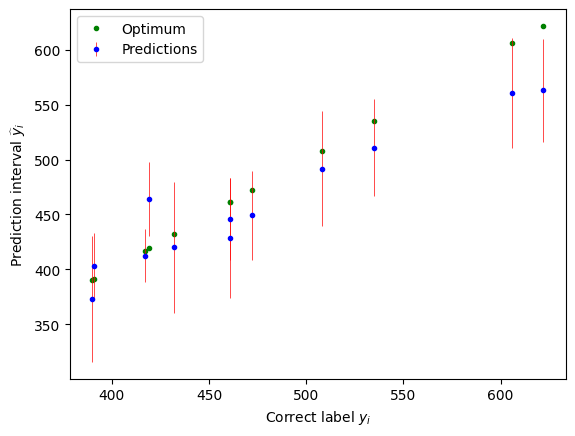

In [12]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_int)

predictive quantile calibration plot

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

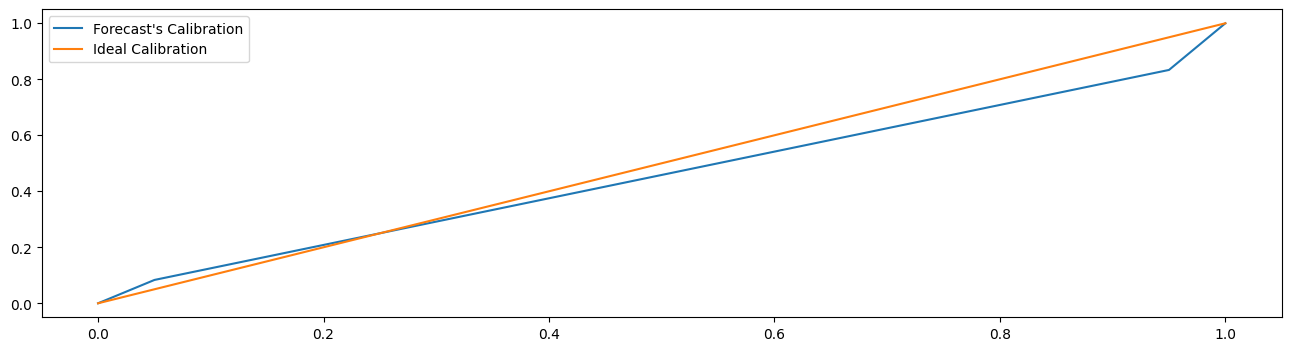

In [16]:
from sktime.utils.plotting import plot_calibration

plot_calibration(y_test, y_pred_q)

developer note:

* most (not all) metrics currently exist in `sktime` *and* `skpro`
* for most use cases, it should not matter which you pick - if in doubt, use same package
* current ongoing refactor to unify `sktime` and `skpro` proba metrics, move to `skpro`

---
### Tabular probabilistic predictions and reduction

"I want to use `mapie` / `ngboost` / [insert favourite proba reducer here] for forecasting!"

challenge: `mapie` / `ngboost` etc are *tabular* probabilistic regressors, not forecasters

same principle as with reduction for point forecasts can be applied! Recall:

![](./img/forecasting-to-regression-reduction.png)

`skpro` is a package with unified interface for:

* probability distribution objects (see above)
* tabular probabilistic regressors
* tabular time-to-event predictors

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.model_selection import train_test_split

from skpro.regression.bootstrap import BootstrapRegressor
from sklearn.linear_model import LinearRegression

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - bootstrap regressor applied to linear regression
reg_tabular = LinearRegression()
boot_reg = BootstrapRegressor(reg_tabular)

# step 3: fitting the model to training data
boot_reg.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = boot_reg.predict_proba(X_test)
y_pred_int = boot_reg.predict_interval(X_test)

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'target'}, ylabel='204'>,
        <Axes: ylabel='213'>, <Axes: ylabel='132'>, <Axes: ylabel='143'>,
        <Axes: ylabel='228'>], dtype=object))

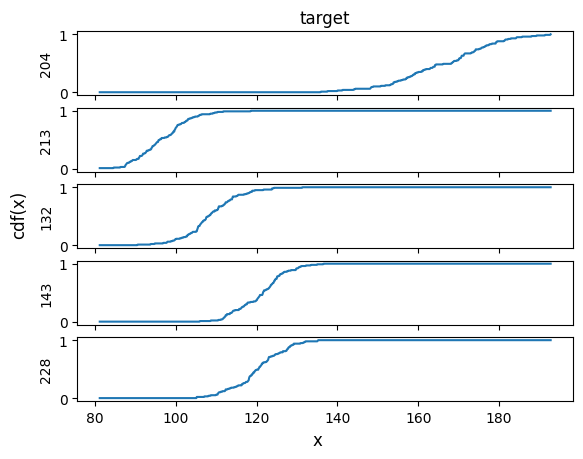

In [29]:
y_pred_proba.head().plot()

In [31]:
# compare lower_upper 90% interval with cdf plot
y_pred_int.head()

target            
            0.9            
          lower       upper
204  143.983356  184.346641
213   87.469724  108.417188
132   97.755279  119.503078
143  111.606720  130.667071
228  108.582920  130.794781

`skpro` can be used on its own if your problem is non temporally ordered!

`skpro` regressors can be used inside (many of the) `sktime` reducers:

In [40]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.compose._reduce import DirectTabularRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = DirectTabularRegressionForecaster(boot_reg, window_length=16)

# fit the forecaster
forecaster.fit(y=y_train, fh=fh)

# make proba prediction
y_pred_int = forecaster.predict_interval()

In [41]:
y_pred_int

Number of shampoo sales            
                            0.9            
                          lower       upper
Period                                     
1993-07              152.555980  307.734264
1993-08              171.966825  334.026027
1993-09              226.000000  340.067524
1993-10              238.148052  608.494118
1993-11              236.455838  453.692900
1993-12              264.500000  392.009877
1994-01              164.673839  345.524858
1994-02              141.159591  483.474235
1994-03               99.600000  425.065691
1994-04              264.579761  474.468253
1994-05              328.581826  439.300000
1994-06              301.526762  480.231876

to build pipelines flexibly, use `YfromX` with `Lag`

Example: building a feature extraction pipeline with 1 lag and fourier features

In [54]:
from sktime.datasets import load_longley
from sktime.forecasting.compose import YfromX
from sktime.transformations.compose import YtoX
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.lag import Lag

# multivariate data with exogenous variables
y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)


# forecaster that predicts y from exogenous X
f = YfromX(boot_reg)

# we add a lag of 1 to exogeneous X
lagged_y_trafo = YtoX() * Lag(1, index_out="original") * Imputer()
# we need to specify index_out="original" as otherwise ARIMA gets 1 and 2 ahead
# we need to add imputer, or the lagged y will have missing values in the first row

# fourier features
fourier_features = FourierFeatures(sp_list=[24, 24 * 7], fourier_terms_list=[10, 5])

# forecaster that uses fourier features and lagged y
forecaster = (lagged_y_trafo + fourier_features)**f 

forecaster.fit(y_train, X=X_train, fh=[1])  # try to forecast next year

y_pred = forecaster.predict(X=X_test)  # dummy X to predict next year
y_pred_proba = forecaster.predict_proba(X=X_test)  # dummy X to predict next year

In [55]:
y_pred_proba.quantile([0.1, 0.5, 0.9])

TOTEMP                           
                 0.1           0.5          0.9
Period                                         
1959    65233.952694  66277.039016  67372.27552

... integration is work in progress.

Wishlists and user feedback appreciated!

[skpro issue tracker](https://github.com/sktime/skpro/issues)

[sktime issue tracker](https://github.com/sktime/sktime/issues)

[community discord](https://discord.com/invite/54ACzaFsn7)

---
## Easy to extend!

For 3rd party code base, your own package (listing at `sktime`), or in `sktime`

All objects above are first class citizens with their own extension templates!

* probability distributions
* probabilistic metrics
* tabular probabilistic regressors
* probabilistic forecasters, of course

["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)

use extension template from `sktime` or `skpro`, folder `extension_templates`

---
## Under development - join to contribute!

* uniformization/refactor `sktime` / `skpro`
* simulation interface for temporally dependent forecasts
* distribution forecast related meta-algorithms such as calibration, pipeline elements
* hierarchical reconcilers for probabilistic forecasters
* Bayesian probabilistic interfaces, `pymc` based models

---
## Summary

`sktime`:

* unified API for probabilistic forecasting and probabilistic metrics
* integrating other packages (e.g. scikit-learn, statsmodels, pmdarima, prophet)
* interface for composite model building is same, proba or not (pipelining, ensembling, tuning, reduction)
* easily extensible with custom estimators

### Credits

notebook creation: fkiraly

probablistic forecasting framework: fkiraly, kejsitake\
probabilistic metrics, tuning: eenticott-shell, fkiraly\
probabilistic estimators: aiwalter, fkiraly, ilyasmoutawwakil, k1m190r, kejsitake